In [102]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm
from PIL import Image
import torch
from segment_anything import sam_model_registry, SamPredictor
from torch.utils.data import DataLoader
from transformers import SamModel, SamConfig, SamProcessor
from skimage.filters import threshold_local
from easyocr import Reader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from difflib import get_close_matches
import re
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\adamain\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
from torch.utils.data import Dataset



In [103]:
image_path = r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\19 - 1.JPG"

In [104]:
def imshow(title = "Image", image = None, size = 10):
    w= image.shape[0]
    h=image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [105]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [106]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["image"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [107]:
import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor

# Load SAM model
# sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth")  # Download the .pth file first
# sam.to("cuda" if torch.cuda.is_available() else "cpu")
# # Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [108]:
IMG_SIZE = 768
WIDTH = 1147

image_paths = glob.glob(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\*.jpg")
allImages = []
#resizing and normalizing every image
for imgFile in tqdm(image_paths, total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (WIDTH, IMG_SIZE))
  img = img/255.0
  allImages.append(img)



images = np.array(allImages)
print(images.shape)

100%|██████████| 69/69 [00:05<00:00, 12.77it/s]


(69, 768, 1147, 3)


In [109]:
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
}

In [110]:
from datasets import Dataset
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


dataset

Dataset({
    features: ['image'],
    num_rows: 69
})

In [111]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [112]:
from torch.utils.data import DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=collate_fn)


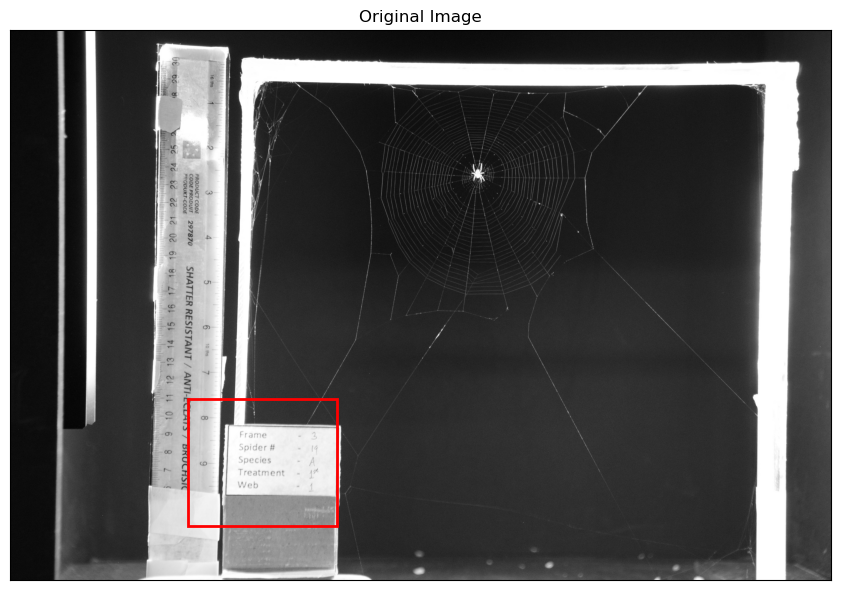

In [113]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
#my_mito_model.load_state_dict(torch.load()) #may need to change the file here
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)


# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)
#function to find the coordinates of the box- restricted to the bottom left quadrant of the screen
def auto_detect_prompt(gray_image, box_width=700, box_height=600, step=20):
    height, width = gray_image.shape
    best_score = float('inf')  # Lower is better: dark-on-bright
    best_box = None

    # Search bottom-left quadrant
    x_max = max(0, width // 2 - box_width)
    y_max = max(0, height - box_height)

    for y in range(height // 2, y_max, step):
        for x in range(0, x_max, step):
            patch = gray_image[y:y + box_height, x:x + box_width]
            if patch.shape[0] != box_height or patch.shape[1] != box_width:
                continue

            # Focus on middle horizontal band (to ignore border noise)
            band = patch[box_height // 4: 3 * box_height // 4, :]

            # Bright background? (we want high average)
            bg_mean = np.mean(band)

            # Detect dark text by thresholding
            _, binary = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            text_score = np.mean(binary == 0)  # fraction of black pixels

            # Invert score: we want high brightness and some dark text
            score = -bg_mean + (text_score * 100)

            if score < best_score:
                best_score = score
                best_box = [x, y, x + box_width, y + box_height]

    if best_box:
        return best_box
    else:
        return [0, height // 2, box_width, height]

prompt = auto_detect_prompt(original_grayscale)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[prompt]],       # Use detected bounding box
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with bounding box overlay
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

# Original Image
axes.imshow(original_grayscale, cmap='gray')
axes.set_title("Original Image")
axes.add_patch(plt.Rectangle((prompt[0], prompt[1]),
                              prompt[2]-prompt[0],
                              prompt[3]-prompt[1],
                              fill=False, edgecolor='red', linewidth=2))

# Formatting

axes.set_xticks([])
axes.set_yticks([])

plt.tight_layout()
plt.show()


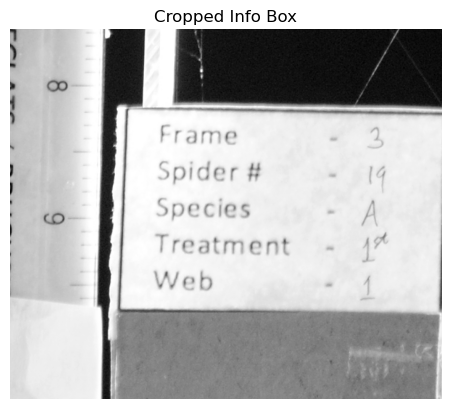

In [114]:
#Displays the cropped box
#Getting some kind of image overlay to find the exact area containing the text would be useful as suggested by Gabriel
x1, y1, x2, y2 = prompt
cropped_image = original_grayscale[y1:y2, x1:x2]
cv2.imwrite("C:\Files\Araneus diadematus\Processed Images\processedcropped.jpg", cropped_image)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()


In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_to_text_region(img, template_img=None, output_path=None, show_steps=True):
    """
    Crop an image to focus on the text region using template matching if a template is provided,
    otherwise fall back to white box detection.
    
    Args:
        img: Input image as numpy.ndarray (can be grayscale or color)
        template_img: Template image (your ideal cropped region) for template matching
        output_path: Path to save the cropped image (optional)
        show_steps: Whether to display intermediate processing steps
    
    Returns:
        Cropped image as numpy array (same format as input)
    """
    
    # Validate input
    if not isinstance(img, np.ndarray):
        raise ValueError("Input must be a numpy.ndarray")
    
    # Handle both grayscale and color images
    if len(img.shape) == 2:
        is_grayscale = True
        original = img.copy()
        gray = img.copy()
    elif len(img.shape) == 3 and img.shape[2] == 3:
        is_grayscale = False
        original = img.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Input image must be either grayscale (2D) or 3-channel color image")
    
    height, width = gray.shape
    
    if show_steps:
        plt.figure(figsize=(20, 15))
        plt.subplot(3, 4, 1)
        if is_grayscale:
            plt.imshow(original, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
    
    # Use template matching if template is provided
    if template_img is not None:
        crop_x1, crop_y1, crop_x2, crop_y2 = template_match_crop(
            gray, template_img, show_steps, original, is_grayscale
        )
    else:
        # Fall back to white box detection
        crop_x1, crop_y1, crop_x2, crop_y2 = white_box_detection_crop(
            gray, show_steps, original, is_grayscale, width, height
        )
    
    # Crop the image
    cropped = original[crop_y1:crop_y2, crop_x1:crop_x2]
    
    if show_steps:
        plt.subplot(3, 4, 5)
        if is_grayscale:
            plt.imshow(cropped, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title('Final Cropped Result')
        plt.axis('off')
        
        # Show original with crop overlay
        plt.subplot(3, 4, 6)
        overlay = original.copy()
        if not is_grayscale:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        else:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
        
        cv2.rectangle(overlay, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 3)
        plt.imshow(overlay)
        plt.title('Original with Crop Region')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Original size: {width}x{height}")
        print(f"Final crop coordinates: ({crop_x1}, {crop_y1}) to ({crop_x2}, {crop_y2})")
        print(f"Cropped size: {crop_x2-crop_x1}x{crop_y2-crop_y1}")
    
    if output_path:
        cv2.imwrite(output_path, cropped)
        print(f"Cropped image saved to {output_path}")
    
    return cropped

def template_match_crop(gray, template_img, show_steps, original, is_grayscale):
    """
    Use template matching to find the region that matches the template.
    """
    # Convert template to grayscale if needed
    if len(template_img.shape) == 3:
        template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template_img.copy()
    
    template_h, template_w = template_gray.shape
    
    if show_steps:
        plt.subplot(3, 4, 2)
        plt.imshow(template_gray, cmap='gray')
        plt.title(f'Template\n{template_w}x{template_h}')
        plt.axis('off')
    
    # Try multiple template matching methods
    methods = [
        ('TM_CCOEFF_NORMED', cv2.TM_CCOEFF_NORMED),
        ('TM_CCORR_NORMED', cv2.TM_CCORR_NORMED),
        ('TM_SQDIFF_NORMED', cv2.TM_SQDIFF_NORMED)
    ]
    
    best_match = None
    best_confidence = -1
    best_method = None
    
    for method_name, method in methods:
        result = cv2.matchTemplate(gray, template_gray, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if method == cv2.TM_SQDIFF_NORMED:
            confidence = 1 - min_val
            match_loc = min_loc
        else:
            confidence = max_val
            match_loc = max_loc
        
        if confidence > best_confidence:
            best_confidence = confidence
            best_match = match_loc
            best_method = method_name
    
    if show_steps:
        plt.subplot(3, 4, 3)
        if best_method == 'TM_SQDIFF_NORMED':
            result = cv2.matchTemplate(gray, template_gray, cv2.TM_SQDIFF_NORMED)
        else:
            result = cv2.matchTemplate(gray, template_gray, cv2.TM_CCOEFF_NORMED)
        plt.imshow(result, cmap='hot')
        plt.title(f'Template Match Result\n{best_method}')
        plt.colorbar()
        plt.axis('off')
    
    # Exact match region (no padding)
    top_left = best_match
    crop_x1, crop_y1 = top_left
    crop_x2 = crop_x1 + template_w
    crop_y2 = crop_y1 + template_h
    
    if show_steps:
        plt.subplot(3, 4, 4)
        match_img = gray.copy()
        match_img = cv2.cvtColor(match_img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(match_img, top_left, (crop_x2, crop_y2), (0, 255, 0), 2)
        plt.imshow(match_img)
        plt.title(f'Match Found\nConfidence: {best_confidence:.3f}')
        plt.axis('off')
        
        print(f"Template matching - Method: {best_method}, Confidence: {best_confidence:.3f}")
        print(f"Match location: {top_left}")
    
    return crop_x1, crop_y1, crop_x2, crop_y2
    
    # Calculate crop coordinates
    top_left = best_match
    crop_x1, crop_y1 = top_left
    crop_x2 = crop_x1 + template_w
    crop_y2 = crop_y1 + template_h
    
    # Add small padding if there's room
    padding = 5
    crop_x1 = max(0, crop_x1 - padding)
    crop_y1 = max(0, crop_y1 - padding)
    crop_x2 = min(gray.shape[1], crop_x2 + padding)
    crop_y2 = min(gray.shape[0], crop_y2 + padding)
    
    if show_steps:
        plt.subplot(3, 4, 4)
        match_img = gray.copy()
        match_img = cv2.cvtColor(match_img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(match_img, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 2)
        cv2.rectangle(match_img, top_left, (top_left[0] + template_w, top_left[1] + template_h), (0, 255, 0), 2)
        plt.imshow(match_img)
        plt.title(f'Match Found\nConfidence: {best_confidence:.3f}\nGreen=exact, Red=with padding')
        plt.axis('off')
        
        print(f"Template matching - Method: {best_method}, Confidence: {best_confidence:.3f}")
        print(f"Match location: {top_left}")
    
    return crop_x1, crop_y1, crop_x2, crop_y2

def white_box_detection_crop(gray, show_steps, original, is_grayscale, width, height):
    """
    Fallback method using white box detection.
    """
    _, white_thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    if show_steps:
        plt.subplot(3, 4, 2)
        plt.imshow(white_thresh, cmap='gray')
        plt.title('White Regions (Fallback)')
        plt.axis('off')
    
    contours, _ = cv2.findContours(white_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidate_boxes = []
    min_area = (width * height) * 0.05
    max_area = (width * height) * 0.8
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(contour)
            edge_margin = 10
            if (x > edge_margin and y > edge_margin and 
                x + w < width - edge_margin and y + h < height - edge_margin):
                aspect_ratio = w / h
                if 0.8 < aspect_ratio < 4.0:
                    rect_area = w * h
                    rectangularity = area / rect_area
                    if rectangularity > 0.7:
                        candidate_boxes.append({
                            'bbox': (x, y, w, h),
                            'area': area,
                            'rectangularity': rectangularity,
                            'aspect_ratio': aspect_ratio
                        })
    
    if candidate_boxes:
        # Select best box (same logic as before)
        best_box = max(candidate_boxes, key=lambda b: b['rectangularity'])
        x, y, w, h = best_box['bbox']
        
        padding = 5
        crop_x1 = max(0, x - padding)
        crop_y1 = max(0, y - padding)
        crop_x2 = min(width, x + w + padding)
        crop_y2 = min(height, y + h + padding)
    else:
        # Ultimate fallback
        crop_x1, crop_y1, crop_x2, crop_y2 = fallback_crop_coordinates(width, height)
    
    if show_steps:
        plt.subplot(3, 4, 3)
        fallback_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(fallback_img, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 2)
        plt.imshow(fallback_img)
        plt.title('Fallback Detection')
        plt.axis('off')
    
    return crop_x1, crop_y1, crop_x2, crop_y2

def crop_with_template_from_path(img, template_path, output_path=None, show_steps=False):
    """
    Convenience function to crop using a template image from file path.
    
    Args:
        img: Input image as numpy.ndarray
        template_path: Path to template image file
        output_path: Path to save the cropped image (optional)
        show_steps: Whether to display intermediate processing steps
    
    Returns:
        Cropped image as numpy array
    """
    template_img = cv2.imread(template_path)
    if template_img is None:
        raise ValueError(f"Could not read template image from {template_path}")
    
    return crop_to_text_region(img, template_img, output_path, show_steps)

def create_template_from_manual_crop(img, x1, y1, x2, y2, template_save_path):
    """
    Create a template by manually cropping a region from an image.
    
    Args:
        img: Input image
        x1, y1: Top-left corner of crop region
        x2, y2: Bottom-right corner of crop region
        template_save_path: Path to save the template image
    
    Returns:
        Template image as numpy array
    """
    template = img[y1:y2, x1:x2]
    cv2.imwrite(template_save_path, template)
    print(f"Template saved to {template_save_path}")
    return template

def fallback_crop_coordinates(width, height):
    """
    Generate fallback crop coordinates when no white box is detected.
    """
    crop_x1 = int(width * 0.1)
    crop_y1 = int(height * 0.4) 
    crop_x2 = int(width * 0.9)
    crop_y2 = int(height * 0.95)
    
    return crop_x1, crop_y1, crop_x2, crop_y2

def center_crop(img, scale=0.6):
    """
    Fallback: crop the center portion of the image.
    """
    if len(img.shape) == 2:
        h, w = img.shape
    else:
        h, w = img.shape[:2]
    
    crop_h = int(h * scale)
    crop_w = int(w * scale)
    
    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2
    
    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

def crop_with_manual_box(img, x1, y1, x2, y2):
    """
    Crop image with manually specified coordinates.
    """
    return img[y1:y2, x1:x2]

def batch_crop_images(images, template_img=None, output_dir="cropped_images", image_names=None):
    """
    Crop multiple images in batch, optionally using a template.
    
    Args:
        images: List of numpy.ndarray images
        template_img: Optional template image for template matching
        output_dir: Directory to save cropped images
        image_names: Optional list of names for the images (without extension)
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        try:
            if image_names and i < len(image_names):
                filename = f"{image_names[i]}.jpg"
            else:
                filename = f"cropped_{i+1}.jpg"
            
            output_path = os.path.join(output_dir, filename)
            cropped = crop_to_text_region(img, template_img, output_path)
            print(f"Successfully processed image {i+1}")
        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")

def load_image_from_path(image_path):
    """
    Helper function to load an image from file path.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    return img

Template matching - Method: TM_CCORR_NORMED, Confidence: 0.963
Match location: (193, 135)


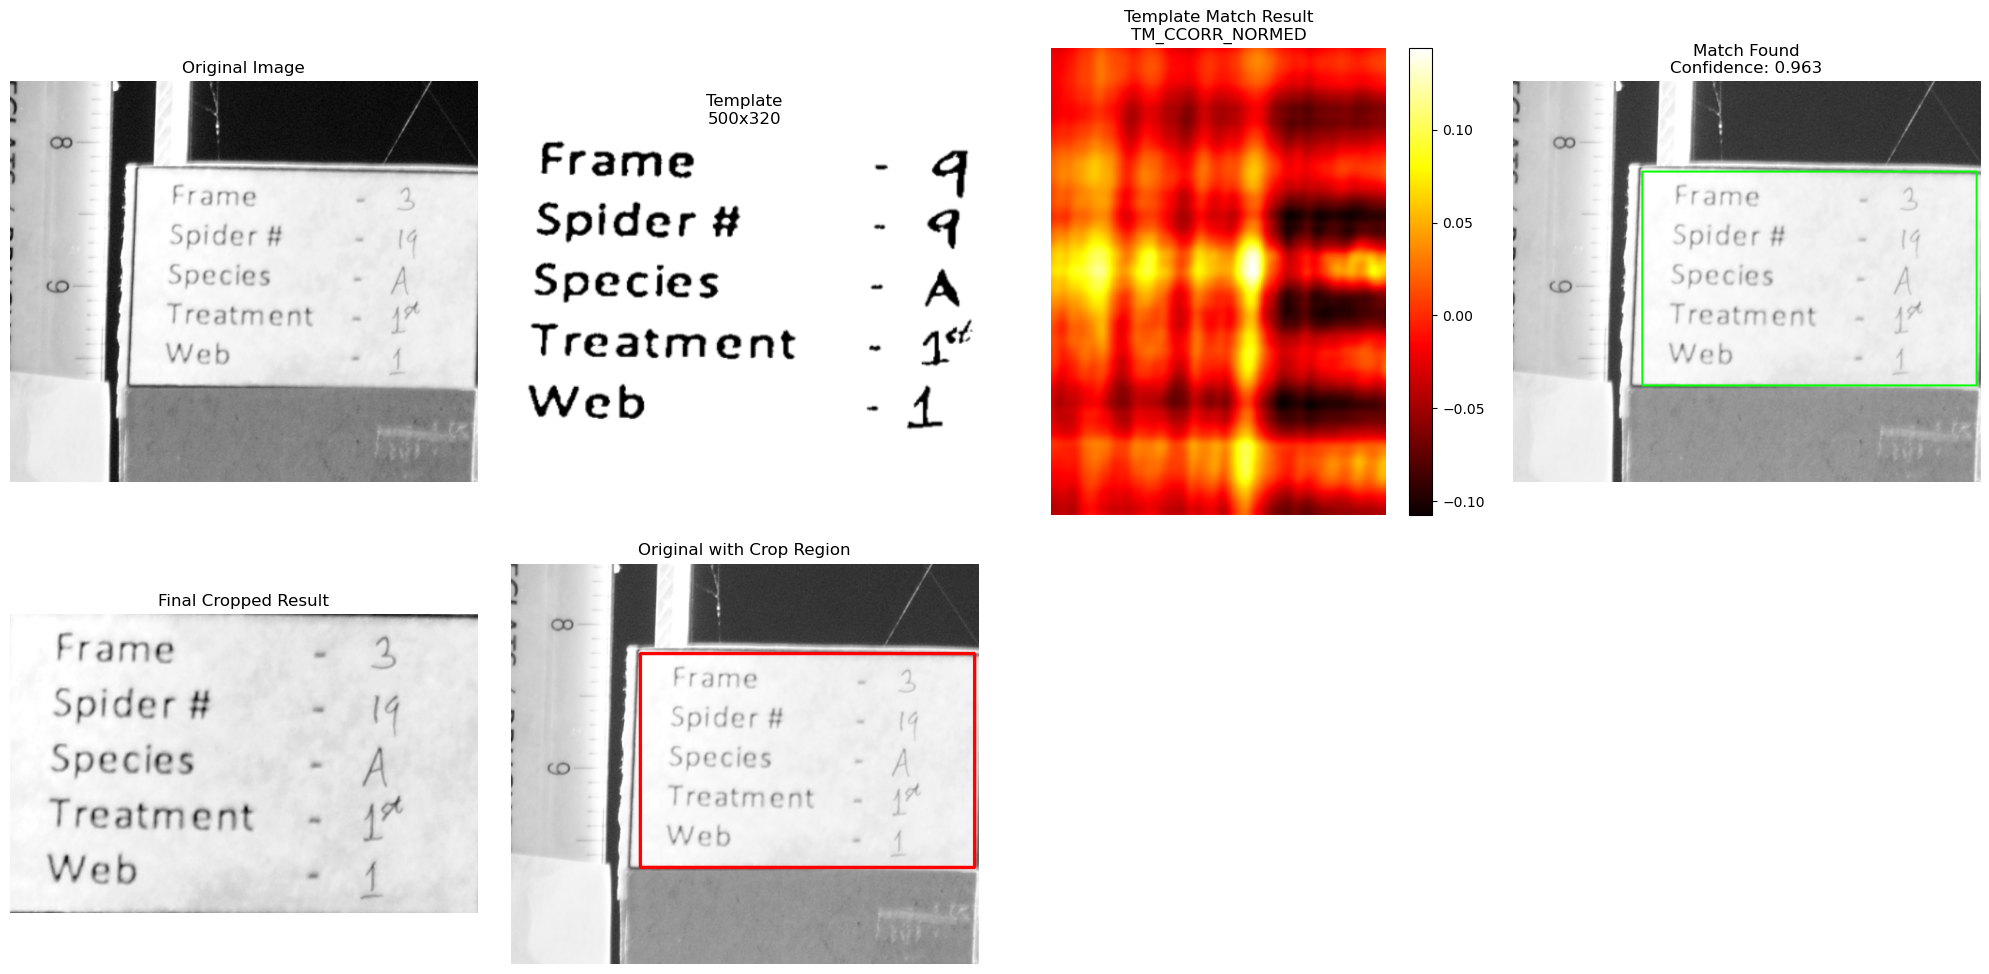

Original size: 700x600
Final crop coordinates: (193, 135) to (693, 455)
Cropped size: 500x320


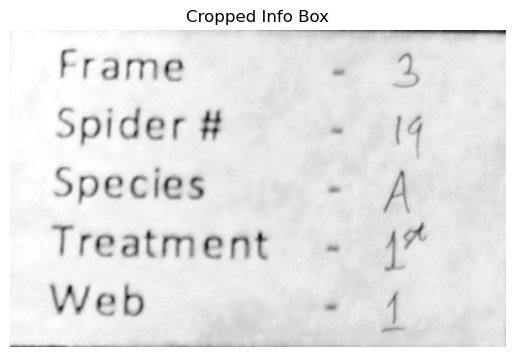

In [116]:
#Maybe try updating the template matching function to make a box of the same size. It always should be around 500x300
croptemplate_img = cv2.imread(r"C:\Files\Araneus diadematus\Processed Images\template-cropped.png")
croptemplate = cv2.resize(croptemplate_img, (500, 320))
data = crop_to_text_region(cropped_image, croptemplate)
plt.imshow(data, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()

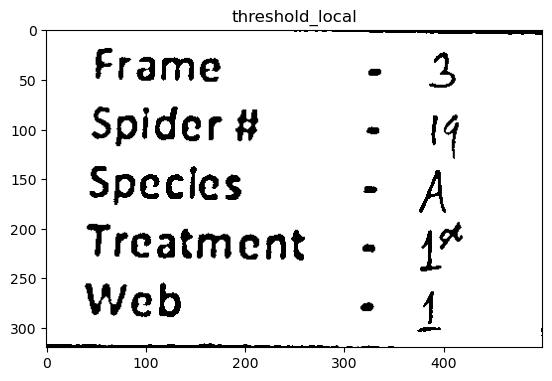

In [117]:
# We get the Value component from the HSV color space. 
# then we apply adaptive thresholding to
from skimage.filters import threshold_local
color_image = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
hsv_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)
Values = cv2.split(hsv_image)[2]
Threshold = threshold_local(Values, 25, offset=15, method="median")
# Apply the threshold operation
thresh = (Values > Threshold).astype("uint8") * 255 #image to display with threshold editing done to it. changes all values to either black (0) if below threshold or white (255) if above threshold 
imshow("threshold_local", thresh)


In [118]:
import cv2
import numpy as np
from sklearn.cluster import AgglomerativeClustering
def segment_lines(img, expected_lines=5, line_height=80, resize_height=64):
    """
    Segments an image into a fixed number of horizontal lines.
    Uses morphological filtering and fallback to uniform slicing.
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize size (helps standardize detection)
    target_height = expected_lines * line_height
    scale = target_height / img.shape[0]
    img_resized = cv2.resize(img, (int(img.shape[1] * scale), target_height), interpolation=cv2.INTER_LINEAR)

    # Apply morphological close to unify text lines
    blur = cv2.GaussianBlur(img_resized, (5, 5), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_resized.shape[1] * 0.5), 5))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    line_boxes = [cv2.boundingRect(c) for c in contours]
    line_boxes = sorted(line_boxes, key=lambda b: b[1])  # sort top to bottom

    line_imgs = []
    for box in line_boxes:
        x, y, w, h = box
        if h < 20:  # filter out small blobs
            continue
        line = img_resized[y:y+h, x:x+w]
        if resize_height is not None:
            scale = resize_height / line.shape[0]
            new_w = int(line.shape[1] * scale)
            line = cv2.resize(line, (new_w, resize_height), interpolation=cv2.INTER_LINEAR)
        line_imgs.append(line)

    # If line detection failed or count doesn't match, fallback to fixed slicing
    if len(line_imgs) != expected_lines:
        h = img_resized.shape[0]
        slice_height = h // expected_lines
        line_imgs = [
            cv2.resize(img_resized[i*slice_height:(i+1)*slice_height], (img_resized.shape[1], resize_height))
            for i in range(expected_lines)
        ]

    return line_imgs

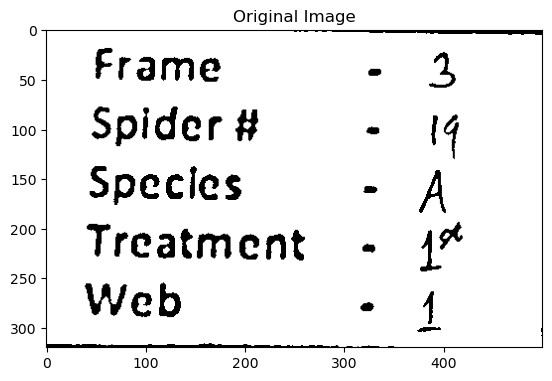

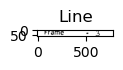

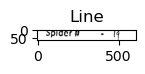

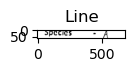

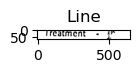

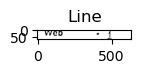

In [119]:
imshow("Original Image", thresh)
lines = segment_lines(thresh) #returns a list of images of each line
for i in lines:
    linenum = 1
    imshow("Line", i, size = 12)
    linenum += 1

In [120]:
def crop_line_values(lines, crop_ratio=0.6, margin=10):
    """
    Crop each line image to focus only on the right-side value content.

    Args:
        lines (list of np.ndarray): List of line images.
        crop_ratio (float): Fraction of image width to skip (left side).
        margin (int): Padding added to right-side content for OCR.

    Returns:
        list of np.ndarray: Cropped line images containing only the value part.
    """
    cropped_values = []

    for idx, line in enumerate(lines):
        h, w = line.shape[:2]
        start_x = int(w * crop_ratio)
        end_x = w

        # Slightly expand the region if possible
        cropped = line[:, start_x:end_x]
        if margin > 0:
            pad_left = min(start_x, margin)
            cropped = line[:, start_x - pad_left:end_x]

        cropped_values.append(cropped)

    return cropped_values


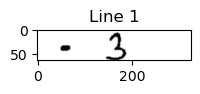

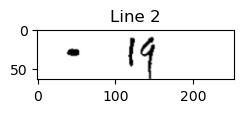

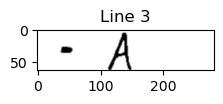

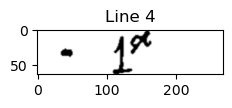

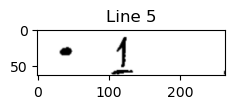

In [121]:
spider_info = crop_line_values(lines)
linenum = 1
for i in spider_info:
    imshow("Line " + str(linenum), i)
    cv2.imwrite("C:\Files\Araneus diadematus\Processed Images\processed" + str(linenum) + ".jpg", i)
    linenum+=1

In [122]:
from difflib import SequenceMatcher
import easyocr
#Get models to read the text
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")
reader = easyocr.Reader(['en'], gpu=False)

EXPECTED_VALUES = {
    0: {'9', '3', '10', '14', '11', '16', '6', '7', '15', '1', '17', '19', '12', '13'},
    1: {'9', '19', '25', '26', '29', '32', '36', '39', '40', '41', '42', '43', '48', '49', '50', '56', '58'},
    2: {'A'},
    3: {'1ST', 'NA'},
    4: {'1', '2', '3', '4', '5', 'CONTROL', 'C'},
}

# Updated preprocessing to reduce damage to sparse characters
def preprocess_value_image(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    h, w = gray.shape
    cropped = gray[:, int(w * 0.1):]  # Keep 90% of the image

    # Threshold
    _, binary = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize and pad to center the text
    resized = cv2.resize(binary, (256, 64), interpolation=cv2.INTER_NEAREST)
    padded = cv2.copyMakeBorder(resized, 16, 16, 16, 16, cv2.BORDER_CONSTANT, value=255)

    return padded

# Clean and standardize OCR text
def clean_ocr_text(text):
    if not text:
        return ""
    text = text.strip().upper()
    text = re.sub(r'(\d+)(ST|ND|RD|TH)\b', r'\1', text)
    text = re.sub(r'[^A-Z0-9]', '', text)
    return text
from difflib import SequenceMatcher

# Confusion fix map for heuristic matching
confusion_map = {
    'TIM': '1ST', '1M': '1ST', 'IM': '1ST', 'IST': '1ST', 'I5T': '1ST',
    '6': '14', 'G': '6', 'O': '0', 'C1': '1', 'CI': '1',
}

from difflib import SequenceMatcher

def clean_and_match(text, expected_set, index=None):
    if not text:
        return '', 0.0

    original = text
    text = clean_ocr_text(text)

    # Heuristics: fix common OCR confusions
    confusion_map = {
        'TIM': '1ST', '1M': '1ST', 'IM': '1ST', 'IST': '1ST',
        'C': 'CONTROL', 'O': '0', 'L': '1'
    }
    if text in confusion_map and confusion_map[text] in expected_set:
        return confusion_map[text], 1.0

    if index == 3:  # Line 4: ordinal logic
        text = re.sub(r'(1)([A-Z]{1,2})', '1ST', text)

    best_match = ''
    best_score = 0.0

    for candidate in expected_set:
        score = SequenceMatcher(None, text, candidate).ratio()

        # Penalize mismatched lengths in Line 1 slightly
        if index == 0 and abs(len(text) - len(candidate)) >= 1:
            score -= 0.1

        if score > best_score:
            best_match = candidate
            best_score = score

    threshold = 0.55 if index == 0 else 0.5
    return best_match if best_score >= threshold else f"Unmatched: {original}", best_score

from PIL import Image
import torch


from PIL import Image
import numpy as np
import torch

def run_trocr_on_image(image, processor, model, device='cpu') -> str:
    """
    Run TrOCR model inference on an image (PIL.Image or NumPy array).

    Args:
        image (PIL.Image.Image or np.ndarray): Input image to recognize text from.
        processor: Initialized TrOCRProcessor.
        model: Initialized VisionEncoderDecoderModel.
        device (str): Device to run inference on ('cpu' or 'cuda').

    Returns:
        str: Recognized text from the image.
    """
    model.to(device)

    # Convert NumPy array to PIL Image if needed
    if isinstance(image, np.ndarray):
        # If grayscale (2D), convert to 3D by stacking channels or convert to RGB later
        if image.ndim == 2:
            image = Image.fromarray(image)
        elif image.ndim == 3:
            # Check channel order - usually HWC
            if image.shape[2] == 1:
                image = Image.fromarray(image.squeeze(axis=2))
            else:
                image = Image.fromarray(image)
        else:
            raise ValueError(f"Unexpected image ndarray shape: {image.shape}")

    # Convert to RGB if not already
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Preprocess image and prepare inputs
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate tokens with model
    generated_ids = model.generate(pixel_values)

    # Decode generated tokens to text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text



def hybrid_ocr(cv2_image_list):
    results = []
    for i, img in enumerate(cv2_image_list):
        processed = preprocess_value_image(img)

        expected_set = EXPECTED_VALUES.get(i, set())

        # TrOCR prediction
        trocr_raw = run_trocr_on_image(processed, model = trocr_model, processor = trocr_processor )
        trocr_match, trocr_score = clean_and_match(trocr_raw, expected_set)

        # EasyOCR prediction
        easy_result = reader.readtext(processed, detail=0)
        easy_raw = easy_result[0] if easy_result else ''
        easy_match, easy_score = clean_and_match(easy_raw, expected_set)

        # Choose better score
        if trocr_score >= easy_score:
            final = trocr_match
        else:
            final = easy_match

        print(f"Line {i+1} => TrOCR: {trocr_match} ({trocr_score:.2f}), "
              f"EasyOCR: {easy_match} ({easy_score:.2f}) => Selected: {final}")
        results.append(final)

    return results




Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using CPU. Note: This module is much faster with a GPU.


In [123]:
hybrid_ocr(spider_info)

Line 1 => TrOCR: 3 (1.00), EasyOCR: 3 (1.00) => Selected: 3
Line 2 => TrOCR: 19 (1.00), EasyOCR:  (0.00) => Selected: 19
Line 3 => TrOCR: A (0.67), EasyOCR: A (1.00) => Selected: A
Line 4 => TrOCR: 1ST (0.50), EasyOCR: 1ST (0.50) => Selected: 1ST
Line 5 => TrOCR: 1 (0.67), EasyOCR:  (0.00) => Selected: 1


['3', '19', 'A', '1ST', '1']